# Segmentez des clients d'un site e-commerce

## __1. Introduction__

### __1.1 Contexte__

Olist est une entreprise brésilienne de commerce entièrement numérique, spécialisée dans la relation b-to-c (business to customer). 

Elle cherche continuellement à s'optimiser. Plusieurs axes ont été proposés mais un seul a été retenu pour cette étude: créer un modèle qui sépare la clientèle en fonction de la caractéristique propre de leur groupe respectif afin de mieux répondre à leurs attentes spécifiques. 

Olist a fait appel à nos services de consulting pour mieux comprendre quels sont les différents groupes de clients/ personae qui utilisent sa plateforme et si ces profils sont stables au cours le temps. 

L'étude est divisée en trois partie:
- ✅ Dans la première partie, nous devons déterminer à partir d'une analyse exploratoire quelles sont les caractéristiques que nous allons garder ou générer pour pouvoir générer un modèle de segmentation de la clientèle. Pour ça, Olist nous a fourni une base de données anonymisée comportant des informations sur l’historique de commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017.
> Cette partie a été faite dans le notebook
`Terrien_Audrey_2_notebook_exploration_042023`.
- ✅ Dans la deuxième partie, elle veut que nous leur fournissions un modèle de  segmentation des clients qu’elle pourra utiliser au quotidien et qui pourra l'aider avec ses campagnes de communication. 
> Cette partie a été faite dans le notebook `Terrien_Audrey_2_notebook_essais_042023`.
- Elle veut aussi une proposition de contrat de maintenance du modèle ou des modèles de segmentation des clients se basant sur une analyse de la stabilité des personae établis au cours du temps. 
> Cette partie est traitée dans ce notebook. 

### __1.2 problématique de cette section__
Notre mission est de vérifier si les segments de client établis par les modèles de segmentation sont stables au cours du temps. 

Pour pouvoir faire cela, il faudra passer par plusieurs étapes.


### __1.3 Le sommaire de ce notebook__

Deux types de modèles ont été déployés pour répondre à cette problématique:
- la première qui est basé sur le modèle le plus performant mais qui ne contient pas la notion de récence (la dernière fois que le client a commandé);
- la deuxième qui est basé sur un modèle RFM amélioré. 

__Les étapes suivies__

1. Introduction avec préparation de l'environnment de travail
2. Préparation du cadrage temporel
3. Création des fonctions de création de table
4. Simulations et leurs résultats respectifs
5. Conclusion

### __1.4 Préparation de l'environnement de travail__ 

Avant de pouvoir tester la qualité du modèle au cours du temps, il faut préparer le terrain en important tous les outils nécessaires pour la création du modèle. Ceci englobe l'importation des librairies, des fonctions et des modèles créés dans le notebook précédent. 

#### __1.4.1 Importation des librairies__ 

In [ ]:
# Importation des modules
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importation de toutes les librairies nécéssaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import datetime as dt
from datetime import timedelta
from dateutil.relativedelta import relativedelta
import time
import math

# Importation pour bien faire la segmentation
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from joblib import dump, load

# pour se débarrasser de tous les warnings
import warnings
warnings.filterwarnings('ignore')

# Capacité à lire toutes les colonnes 
pd.set_option('display.max_colwidth', None)

In [ ]:
# Initialisation du paramètre de génération de séquence du nombre aléatoire
from sklearn.utils import check_random_state
random_state = check_random_state(123)
np.random.seed(123)

#### __1.4.2 Récupération des fonctions__

In [ ]:
# Récupération de la fonction - diminution de la mémoire allouée à chaque 
# variable du dataset
def reduce_memory_usage(df):
    # Obtenir l'utilisation initiale de la mémoire du cadre de données
    start_mem = df.memory_usage().sum() / 1024 ** 2
    
    # Boucle sur chaque colonne
    for col in df.columns:
        col_type = df[col].dtype
        
        # Conversion des objets de type catégorie s'il y a moins de 50% 
        # de valeurs uniques
        if col_type == 'object':
            if len(df[col].unique()) / len(df[col]) < 0.5:
                df[col] = df[col].astype('category')
                continue
                
        # Conversion de int64 en int32 si possible 
        if col_type == 'int64':
            col_min = df[col].min()
            col_max = df[col].max()
            if col_min >= np.iinfo(np.int32).min and col_max <= np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
            elif col_min >= np.iinfo(np.int16).min and col_max <= np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
                
        # Conversion de float64 en float32 si possible
        if col_type == 'float64':
            col_min = df[col].min()
            col_max = df[col].max()
            if col == 'monetary_value':
                df[col] = df[col].astype(np.float64)
            elif col_min >= np.finfo(np.float32).min and col_max <= np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
            elif col_min >= np.finfo(np.float16).min and col_max <= np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float32) # parce que float16 n'est pas stable
    
    # Obtention de l'utilisation finale de la mémoire du dataframe
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print(f"Memory usage reduced from {start_mem:.2f} MB to {end_mem:.2f} MB")
    return df

In [ ]:
# Création d'une liste de mois entre deux mois données
def create_month_list(min_month, max_month):
    # Convertir les strings en datetime
    min_month_dt = dt.datetime.strptime(min_month, "%Y-%m")
    max_month_dt = dt.datetime.strptime(max_month, "%Y-%m")
    
    # Initialiser la liste de mois
    month_list = []
    
    # Ajouter chaque mois entre min_month et max_month à la liste
    while min_month_dt <= max_month_dt:
        month_str = min_month_dt.strftime("%Y-%m")
        month_list.append(month_str)
        min_month_dt += relativedelta(months=1)
    
    return month_list

#### __1.4.3 Récupération des pipelines__

In [ ]:
## Chargement du modèle K-Means SANS la récence depuis le fichier enregistré
pipeline = load("/content/drive/MyDrive/projet_5/data/best_model.joblib")

## Chargement du modèle K-Means AVEC la récence depuis le fichier enregistré
recency_pipeline = load("/content/drive/MyDrive/projet_5/data/recency_model.joblib")

In [ ]:
# Observation de toutes les étapes et les paramètres du modèle SANS la récence
pipeline.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('frequency', Binarizer(threshold=1),
                                    ['frequency']),
                                   ('money',
                                    FunctionTransformer(func=<function discretize_money at 0x7fed8f03c940>),
                                    ['monetary_value']),
                                   ('review',
                                    FunctionTransformer(func=<function discretize_reviews at 0x7fed8f03cca0>),
                                    ['review_length']),
                                   ('score',
                                    FunctionTransformer(func=<function discretize_score at 0x7fed8f03cb80>),
                                    ['score']),
                                   ('delay',
                                    FunctionTransformer(func=<function discretize_delay at 0x7fed830b81f0>),
                                    ['delay_time']

In [ ]:
# Observation de toutes les étapes et les paramètres du modèle AVEC la récence
recency_pipeline.get_params()

{'memory': None,
 'steps': [('preprocessor',
   ColumnTransformer(transformers=[('frequency', Binarizer(threshold=1),
                                    ['frequency']),
                                   ('money',
                                    FunctionTransformer(func=<function discretize_money at 0x7fed8f03c940>),
                                    ['monetary_value']),
                                   ('review',
                                    FunctionTransformer(func=<function discretize_reviews at 0x7fed8f03cca0>),
                                    ['review_length']),
                                   ('score',
                                    FunctionTransformer(func=<function discretize_score at 0x7fed8f03cb80>),
                                    ['score']),
                                   ('delay',
                                    FunctionTransformer(func=<function discretize_delay at 0x7fed830b81f0>),
                                    ['delay_time']

In [ ]:
# Vérification des noms des variables qui devront être recréées ou récupérées
# dans l'étape de création d'une table mensuelle pour utiliser le modèle de base
pipeline.feature_names_in_

array(['frequency', 'monetary_value', 'delivery_time', 'delay_time',
       'score', 'review_length'], dtype=object)

In [ ]:
# Vérification des noms des variables qui devront être recréées ou récupérées
# dans l'étape de création d'une table mensuelle pour utiliser le modèle recency
recency_pipeline.feature_names_in_

array(['recency', 'frequency', 'monetary_value', 'delivery_time',
       'delay_time', 'score', 'review_length'], dtype=object)

In [ ]:
# Création d'une liste avec toutes les variables pour le modèle SANS la récence
ft_list = list(pipeline.feature_names_in_)

# Création d'une liste avec toutes les variables pour le modèle AVEC la récence
ft_list_recency = list(recency_pipeline.feature_names_in_)

## __2. Préparation du cadrage pour déterminer l'ARI correctement__

__Déterminer la fenêtre de temps sur laquelle la stabilité du modèle va se baser__

In [ ]:
# Définir une fonction pour calculer le nombre de commandes par jour
orders = pd.read_csv("/content/drive/MyDrive/projet_5/data/olist_orders_dataset.csv")
def df_nb_orders(time_feature, name_feature):
    df = orders[['order_id', time_feature]]
    df['date'] = pd.to_datetime(df[time_feature]).dt.date
    df[name_feature] = df.groupby(['date'])['order_id'].transform('nunique')
    df = df.drop(columns = ['order_id', time_feature]).drop_duplicates() 
    df['date'] = pd.to_datetime(df['date'])
    return df

# Calculer le nombre de commandes par jour pour l'achat, la livraison estimée et la livraison
df_purchase = df_nb_orders('order_purchase_timestamp', "Nombre de paniers achetés")
df_estimated = df_nb_orders('order_estimated_delivery_date', "Nombre de paniers à délivrer en théorie")
df_delivered = df_nb_orders('order_delivered_customer_date', "Nombre de paniers délivrés")

# Remplacement des valeurs nulles par 0
df_time = pd.merge(df_purchase, df_estimated, on=["date"], how="outer")
df_time = pd.merge(df_time, df_delivered, on=["date"], how="outer")

date_range = pd.date_range(start=df_time['date'].min().to_pydatetime(),
                           end=df_time['date'].max().to_pydatetime())

df_time = (df_time.set_index('date')\
           .reindex(date_range).fillna(0)\
           .astype(int).reset_index()\
           .rename(columns={'index': 'date'}))

# Création d'un graphique linéaire du nombre de commandes en fonction du temps
fig = go.Figure()
fig.add_trace(go.Scatter(x=df_time['date'], 
                         y=df_time["Nombre de paniers achetés"],
                         mode='lines',
                         name="Nombre de paniers achetés"))

fig.add_trace(go.Scatter(x=df_time['date'], 
                         y=df_time["Nombre de paniers à délivrer en théorie"],
                         mode='lines', 
                         name="Nombre de paniers à délivrer en théorie"))

fig.add_trace(go.Scatter(x=df_time['date'], 
                         y=df_time["Nombre de paniers délivrés"], 
                         mode='lines', 
                         name="Nombre de paniers délivrés"))

# Actualisation de la mise en page
fig.update_layout(title="Nombre de commandes par jour",
                  xaxis_title="Date",
                  yaxis_title="Nombre de commandes",
                  plot_bgcolor='rgba(0,0,0,0)',
                  paper_bgcolor='rgba(0,0,0,0)',
                  width=1500, height=600)

# Visualisation du graphe
fig.show()

# Suppression des éléments devenus inutiles
del(fig, df_delivered, df_estimated, df_purchase, df_time, orders)

Comme nous pouvons le constater lorsque nous regardons la tendances du nombre de paniers délivrés dans le temps, il est divisé en plusieurs parties:
- Entre octobre 2016 et janvier 2017: lancement du site d'Olist
- Entre février 2017 et novembre 2017: début du site et augmentation de sa clientèle
- Entre décembre 2017 et août 2018: confirmation du site et stabilisation de sa clientèle. 

Il commence légèrement à se stabiliser autour de décembre, moment où les gens commence à acheter leurs cadeaux de Noël. C'est un moment intéressant pour faire de la publicité massive et récupérer des nouveaux clients.

Cette dernière phase (décembre 2017 et août 2018) correspond à une période de 9 mois.

Pour la simulation, il serait intéressant dans un premier temps de n'utiliser que cette période et non les périodes précédentes pour ne pas être perturbé par l'évolution rapide que connait le site entre février 2017 et novembre 2017. 

C'est pourquoi, nous allons commencer par observer la stabilité du modèle sur les 9 derniers mois. Si ce dernier se montre relativement stable, nous allons généraliser le processus pour prendre en compte la data dès janvier 2017.  

## __3 Mise en place de fonctions créant des tables ne récupérant que les informations de la période définie préalablement__

Nous allons créer des fonctions qui permettent la mise en place de table similaire à celle que nous avons construite dans le premier notebook mais avec seulement les variables nécessaires et la période prédéterminée.

Nous faisons cela car un client X peut, durant toute sa période chez Olist, avoir acheté à plusieurs reprises avoir commandé sur Olist et avoir adopté un comportement différent à chaque fois. Lorsque nous analysons son comportement, dans son ensemble, il peut finir par être catégoriser dans un certain groupe. Or, si nous ne prenons qu'une période particulière (un mois en l'occurence), son comportement et ses caractéristiques peuvent l'avoir catégorisé dans un autre groupe. 

Ainsi le groupe qui lui a été assigné globalement peut différer du groupe qui lui a été assigné ponctuellement. 

Avant même de construire ces fonctions, nous devons aller récupérer les bouts de scripts qui nous ont permis de créer précédemment la table. 

### __3.1 Récupération du code du premier fichier__

Cette section n'est que la récupération des codes. Vous pouvez le passer, si vous ne souhaitez voir que la création des fonctions.

```
# Conservation uniquement des variables souhaitées
customers = customers[['customer_unique_id', 'customer_id']]
customers = pd.merge(customers, orders, on= 'customer_id', how='left')

# Suppression des commandes qui n'ont pas été délivrées ou supprimées
customers = customers[customers.order_status.isin(['delivered'])]
customers = customers[['customer_unique_id', 'customer_id', 'order_id', 
                       'order_purchase_timestamp', 'order_approved_at', 
                       'order_delivered_customer_date', 
                       'order_estimated_delivery_date']]

# Observation des valeurs manquantes
customers.isna().sum() 
```

```
# Transformation des variables temporelles au format 'datetime'
for feature in ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_customer_date', 'order_estimated_delivery_date']:
  customers[feature] = pd.to_datetime(customers[feature])

# Création de la variable recency
most_recent_order = customers['order_purchase_timestamp'].max()
customers['recency'] =  (most_recent_order - customers['order_purchase_timestamp']).dt.days 
#print(customers.head())
#del(most_recent_order)

# Suppression des lignes sortant du cadre temporel fixé
customers = customers[(customers['order_purchase_timestamp'] >= '2017-12-01') \
            & (customers['order_purchase_timestamp'] < '2018-09-01')]

order_purchase_timestamp_min = customers.order_purchase_timestamp.min()
order_purchase_timestamp_max = customers.order_purchase_timestamp.max()
display(f"Minimum d'order_purchase_timestamp:", order_purchase_timestamp_min,
        40*f"_",
        f"Maximum d'order_purchase_timestamp:", order_purchase_timestamp_max)

# Création de la variable month_year, utile pour vérifier la stabilité du modèle testé
customers['month_year'] = pd.to_datetime(customers['order_purchase_timestamp']).dt.to_period('M')
time_diff = customers['month_year'].nunique()
display(40*f"_",
        f"Différence de mois entre les deux:", time_diff,
        40*f"_")
customers['delivery_time'] = pd.to_datetime(customers['order_delivered_customer_date']) - pd.to_datetime(customers['order_purchase_timestamp'])
customers['delay_time'] = pd.to_datetime(customers['order_delivered_customer_date']) - pd.to_datetime(customers['order_estimated_delivery_date'])
customers['approval_time'] = pd.to_datetime(customers['order_approved_at']) - pd.to_datetime(customers['order_purchase_timestamp'])

# Liste des order_approved_at nulles
order_id_with_wrong_approval_time = customers[customers.order_approved_at.isna()]['order_id'].to_list()
# Liste des order_delivered_customer_date nulles
order_id_with_wrong_delivery_and_delay_time = customers[customers.order_delivered_customer_date.isna()]['order_id'].to_list()
# Premier remplacement 
approval_time_median = customers.approval_time.median()
customers.approval_time.loc[customers.order_id.isin(order_id_with_wrong_approval_time)] = approval_time_median
# # Deuxième remplacement
delivery_time_median = customers.delivery_time.median()
delay_time_median = customers.delay_time.median()
customers.delivery_time.loc[customers.order_id.isin(order_id_with_wrong_delivery_and_delay_time)] = delivery_time_median
customers.delay_time.loc[customers.order_id.isin(order_id_with_wrong_delivery_and_delay_time)] = delay_time_median

# Création de la variable frequency
customers = customers.assign(frequency=customers.groupby('customer_unique_id')['order_id'].transform('count'))
display(customers.head())
```

```
# Variables à créer à partir de reviews
## totalité de caractères utilisé par commande (les titres sont inclus)
reviews = pd.read_csv("/content/drive/MyDrive/projet_5/data/olist_order_reviews_dataset.csv")

# Création des variables review_length, nb_reviews_per_order et review_score
reviews['review_length'] = reviews['review_comment_message'].str.len().replace(np.nan,0) + \
                            reviews['review_comment_title'].str.len().replace(np.nan,0)
reviews['review_length'] = reviews.groupby(['order_id'])['review_length'].transform('sum')
reviews['nb_reviews_per_order'] = reviews.groupby(['order_id'])['review_id'].transform('count')
reviews['review_score'] = reviews.groupby(['order_id'])['review_score'].transform('mean')

## Variables à garder dans reviews
reviews = reviews[['order_id', 'review_score', 'review_length', 'nb_reviews_per_order']]
reviews = reviews.drop_duplicates()
display(reviews.head())
print(len(reviews), len(reviews.drop_duplicates()))
```

```
# Variable à créer à partir d'items
## Nombre d'articles par commande
items = pd.read_csv("/content/drive/MyDrive/projet_5/data/olist_order_items_dataset.csv")

## Création des variables nb_items_per_order, monetary_value, freight_value
items['nb_items_per_order'] = items.groupby('order_id')['order_item_id'].transform('count')
items['monetary_value'] = items['price'] + items['freight_value']
items['monetary_value'] = items.groupby('order_id')['monetary_value'].transform('sum')
items['freight_price'] = items.groupby('order_id')['freight_value'].transform('sum')

## Variables à conserver dans items
items = items[['order_id', 'nb_items_per_order', 'monetary_value', 'freight_price']]
display(items.head())
print(len(items), len(items.drop_duplicates()))
items = items.drop_duplicates()
```

```
# Variables à créer à partir de payments
#payments = pd.read_csv("/content/drive/MyDrive/projet_5/data/olist_order_payments_dataset.csv")

# Création des variables à partir de payments
payments['payment_id'] = payments.index
payments['nb_installments'] = payments.groupby('order_id')['payment_id'].transform('count') 
payments['order_price'] = payments.groupby('order_id')['payment_value'].transform('sum')

## Variable à garder dans payments
payments = payments[['order_id', 'order_price', 'nb_installments']]
display(payments.head())
print(len(payments), len(payments.drop_duplicates()))
payments = payments.drop_duplicates()
```

```
# Fusion de tous les datasets
data = pd.merge(customers, items, on=["order_id"], how="left")
display(data.head())
data = pd.merge(data, payments, on=["order_id"], how="left")
data = pd.merge(data, reviews, on=["order_id"], how="left")
#display(data.isna().sum())

# Traitement des valeurs manquantes pour les champs review_score, review_length et nb_reviews_per_order
data['review_score'].fillna(data['review_score'].median(), inplace=True)
data['review_length'].fillna(data['review_length'].median(), inplace=True)
data['nb_reviews_per_order'].fillna(data['nb_reviews_per_order'].median(), inplace=True)
#display(data.isna().sum())

data = data.groupby(['customer_unique_id', 'month_year']).agg({
   # 'recency': 'min',
    'order_id': 'nunique',
    'monetary_value': 'sum',

    'approval_time': 'mean',
    #'delivery_time': 'mean',
    'delay_time': 'mean',

    'nb_items_per_order': 'mean',
    #'freight_price': 'sum',
    'nb_installments': 'mean',

    'review_score': 'mean',
    'review_length': 'mean',
    #'nb_reviews_per_order': 'mean',
}).reset_index()

# Création de la colonne freight_rate qui est le taux de l'argent total des commandes qui part dans la prix de la livraison 
#data['freight_rate'] = round(data['freight_price'] / data['monetary_value'], 2)

# Suppression du champ qui freigth_price
#data.drop('freight_price', axis=1, inplace=True)

# Renommage de la colonne order_id par frequency
data.rename(columns={'order_id': 'frequency'}, inplace=True)

# Vérification 
#msno.matrix(data)
#display(data.head())

# Arrondissement des valeurs
for col in ['review_length', 'nb_installments', 'nb_items_per_order']:#, 'nb_reviews_per_order']:
  data[col] = round(data[col])

for col in ['monetary_value']:#freight_rate
  data[col] = round(data[col], 2)

# Passage au pourcentage
#data['freight_rate'] = data['freight_rate']*100

# Modification des datetimes en jour/int
#data['recency'] = data['recency'].dt.days 
#data['delivery_time'] = (data['delivery_time'].clip(lower=pd.Timedelta(days=0))
#                                   .map(lambda x: math.ceil(x.total_seconds()/(24*3600)))
#                                   .map(lambda x: pd.Timedelta(days=x))).dt.days
data['delay_time'] = data['delay_time'].clip(lower=pd.Timedelta(days=0)).dt.days
data['approval_time'] = round(data['approval_time'].dt.total_seconds()/3600)

# Liste des variables au futur format int8
int8_variable_list = ['frequency', 'delay_time', #'delivery_time', 
                      'nb_items_per_order', 'nb_installments', 'review_score']
# Liste des variables au futur format int16
int16_variable_list = ['recency', 'approval_time', 'review_length']#, 'freight_rate']

# Liste des variables au futur format float16
#float_variable_list = ['freight_rate']

# Modification du formats des variables pour diminuer le temps de computation pour le prochain fichier
#data.describe()
#data.head()
for col in data.columns.tolist() : 
  if col in int8_variable_list:
    data[col] = data[col].astype("int8")
  if col in int16_variable_list:
    data[col] = data[col].astype("int16") 
  #if col in float_variable_list:
  #  data[col] = data[col].astype("float16") 
  if col == 'monetary_value': 
    data[col] = data[col].astype("float32")
#data.describe()
#data.head()

data.rename(columns=
              {'customer_unique_id': 'customer_id',
              'review_score': 'score'}, 
            inplace=True)
display(data.head())
```

### __3.2 Fonction créatrice de table mensuel (sans la récence)__

In [ ]:
display(date_range.min(), date_range.max())
del date_range

Timestamp('2016-09-04 00:00:00', freq='D')

Timestamp('2018-11-12 00:00:00', freq='D')

In [ ]:
def create_table(month_year='all', beginning_cut='2017-01-01', ending_cut='2018-10-01'):
  # Temps de création du modèle
  start_time = time.time()

  # Récupération des tables de base
  customers = pd.read_csv("/content/drive/MyDrive/projet_5/data/olist_customers_dataset.csv")
  orders = pd.read_csv("/content/drive/MyDrive/projet_5/data/olist_orders_dataset.csv")
  reviews = pd.read_csv("/content/drive/MyDrive/projet_5/data/olist_order_reviews_dataset.csv")
  items = pd.read_csv("/content/drive/MyDrive/projet_5/data/olist_order_items_dataset.csv")
  payments = pd.read_csv("/content/drive/MyDrive/projet_5/data/olist_order_payments_dataset.csv")

  # Conservation uniquement des variables souhaitées
  customers = customers[['customer_unique_id', 'customer_id']].drop_duplicates()
  customers = pd.merge(customers, orders, on= 'customer_id', how='left')

  # Création des médianes des valeurs pouvant manquer
    # Création des variables: delivery_time et delay_time
  customers['delivery_time'] = (pd.to_datetime(
      customers['order_delivered_customer_date']) - 
      pd.to_datetime(customers['order_purchase_timestamp']))
  customers['delay_time'] = (pd.to_datetime(
      customers['order_delivered_customer_date']) - 
      pd.to_datetime(customers['order_estimated_delivery_date']))
  delivery_time_median = customers.delivery_time.median()
  delay_time_median = customers.delay_time.median()
  customers = customers.drop(columns=['delivery_time', 'delay_time'])

  # Suppression des commandes qui n'ont pas été délivrées ou supprimées
  customers = customers[customers.order_status.isin(['delivered'])]

  # Suppression des lignes sortant du cadre temporel fixé
  customers = customers[(customers['order_purchase_timestamp'] >= beginning_cut) \
              & (customers['order_purchase_timestamp'] < ending_cut)]

  # Création de la variable month_year, utile pour vérifier la stabilité du modèle testé
  # Permet de découper la table et de ne conserver que les individus ayant commandé
  # durant cette période
  month = month_year
  customers['month_year'] = (pd
                             .to_datetime(customers['order_purchase_timestamp'])
                             .dt.to_period('M'))

  # Filtrage sur le mois récupéré en argument
  if month_year == 'all':
    customers = customers
  else: 
    # Convert month_year to Period
    if isinstance(month_year, str):
      month_year = [month_year]
      month_year = pd.PeriodIndex(month_year, freq='M')
      customers = customers[customers.month_year.isin(month_year)] 

  # Récupération des variables utiles du mélange orders - customers
  customers = customers[['customer_unique_id', 'customer_id', 'order_id', 'month_year',
                         'order_purchase_timestamp', 'order_delivered_customer_date', 
                         'order_estimated_delivery_date']]

  # Transformation des variables temporelles au format 'datetime'
  for feature in ['order_purchase_timestamp', 'order_delivered_customer_date', 
                  'order_estimated_delivery_date']:
    customers[feature] = pd.to_datetime(customers[feature])

  # Création des variables: delivery_time et delay_time
  customers['delivery_time'] = (pd.to_datetime(
      customers['order_delivered_customer_date']) - 
      pd.to_datetime(customers['order_purchase_timestamp']))
  customers['delay_time'] = (pd.to_datetime(
      customers['order_delivered_customer_date']) - 
      pd.to_datetime(customers['order_estimated_delivery_date']))
  
  # Remplacement des valeurs nulles par la médiane des variables
  order_id_with_wrong_delivery_and_delay_time = (customers[customers
                                                           .order_delivered_customer_date
                                                           .isna()]['order_id']
                                                 .to_list())

  (customers.delivery_time
   .loc[customers.order_id
        .isin(order_id_with_wrong_delivery_and_delay_time)]) = delivery_time_median
  (customers.delay_time
   .loc[customers.order_id
        .isin(order_id_with_wrong_delivery_and_delay_time)]) = delay_time_median

  # Création des variables frequency, review_length, review_score, monetary_value
  customers = (customers.assign(frequency=customers
                                .groupby('customer_unique_id')['order_id']
                                .transform('count')))
  
  reviews['review_length'] = (reviews['review_comment_message'].str
                              .len().replace(np.nan,0) + \
                              reviews['review_comment_title'].str
                              .len().replace(np.nan,0))
  reviews['review_length'] = (reviews
                              .groupby(['order_id'])['review_length']
                              .transform('sum'))
  reviews['review_score'] = (reviews
                             .groupby(['order_id'])['review_score']
                             .transform('mean'))
  reviews = reviews[['order_id', 'review_score', 'review_length']]
  reviews = reviews.drop_duplicates()

  items['monetary_value'] = items['price'] + items['freight_value']
  items['monetary_value'] = (items
                             .groupby('order_id')['monetary_value']
                             .transform('sum'))
  items = items[['order_id', 'monetary_value']]
  items = items.drop_duplicates()

  # Création des variables à partir de payments
  payments['payment_id'] = payments.index
  payments['order_price'] = (payments
                             .groupby('order_id')['payment_value']
                             .transform('sum'))
  payments = payments[['order_id', 'order_price']]
  payments = payments.drop_duplicates()
  
  # Fusion de tous les datasets
  data = pd.merge(customers, items, on=["order_id"], how="left")
  data = pd.merge(data, payments, on=["order_id"], how="left")
  data = pd.merge(data, reviews, on=["order_id"], how="left")

  # Traitement des valeurs manquantes pour les champs review_score, review_length 
  data['review_score'].fillna(data['review_score'].median(), inplace=True)
  data['review_length'].fillna(data['review_length'].median(), inplace=True)

  # 2e fusion 
  data = data.groupby(['customer_unique_id']).agg({
        'order_id': 'nunique',
        'monetary_value': 'sum',
        'delivery_time': 'mean',
        'delay_time': 'mean',
        'review_score': 'mean',
        'review_length': 'mean'}).reset_index()

  # Arrondissement des valeurs et pourcentage
  for col in ['review_length']:
    data[col] = round(data[col])
  for col in ['monetary_value']:
    data[col] = round(data[col], 2)

  # Modification des datetimes en jour/int
  data['delivery_time'] = (data['delivery_time'].clip(lower=pd.Timedelta(days=0))
                                    .apply(lambda x: math.ceil(x.total_seconds()/(24*3600)))
                                    .apply(lambda x: pd.Timedelta(days=x))).dt.days
  data['delay_time'] = data['delay_time'].clip(lower=pd.Timedelta(days=0)).dt.days

  # Modification du formats des variables pour diminuer le temps de computation pour le prochain fichier
  #data = reduce_memory_usage(data)

  # Modification des noms de certaines variables
  data.rename(columns={'customer_unique_id': 'customer_id',
                       'review_score': 'score',
                       'order_id': 'frequency'},
              inplace=True)

  # Réponse à chaque création de table
  if month_year == 'all':
    print(f"The complete table has being created in {(time.time()-start_time):.2f} seconds.")
  else:
    print(f"The table for the {month} period has being created in {(time.time()-start_time):.2f} seconds.")
  return data

### __3.3 Fonction créatrice de table mensuel (avec la récence)__

In [ ]:
def create_table_with_recency(month_year='all', beginning_cut='2017-01-01', ending_cut='2018-10-01'):
  # Temps de création du modèle
  start_time = time.time()

  # Récupération des tables de base
  customers = pd.read_csv("/content/drive/MyDrive/projet_5/data/olist_customers_dataset.csv")
  orders = pd.read_csv("/content/drive/MyDrive/projet_5/data/olist_orders_dataset.csv")
  reviews = pd.read_csv("/content/drive/MyDrive/projet_5/data/olist_order_reviews_dataset.csv")
  items = pd.read_csv("/content/drive/MyDrive/projet_5/data/olist_order_items_dataset.csv")
  payments = pd.read_csv("/content/drive/MyDrive/projet_5/data/olist_order_payments_dataset.csv")

  # Conservation uniquement des variables souhaitées
  customers = customers[['customer_unique_id', 'customer_id']].drop_duplicates()
  customers = pd.merge(customers, orders, on= 'customer_id', how='left')

  # Création des médianes des valeurs pouvant manquer
    # Création des variables: delivery_time et delay_time
  customers['delivery_time'] = (pd.to_datetime(
      customers['order_delivered_customer_date']) - 
      pd.to_datetime(customers['order_purchase_timestamp']))
  customers['delay_time'] = (pd.to_datetime(
      customers['order_delivered_customer_date']) - 
      pd.to_datetime(customers['order_estimated_delivery_date']))
  delivery_time_median = customers.delivery_time.median()
  delay_time_median = customers.delay_time.median()
  customers = customers.drop(columns=['delivery_time', 'delay_time'])

  # Suppression des commandes qui n'ont pas été délivrées ou supprimées
  customers = customers[customers.order_status.isin(['delivered'])]

  # Suppression des lignes sortant du cadre temporel fixé
  customers = customers[(customers['order_purchase_timestamp'] >= beginning_cut) \
              & (customers['order_purchase_timestamp'] < ending_cut)]

  # Création de la variable month_year, utile pour vérifier la stabilité du modèle testé
  # Permet de découper la table et de ne conserver que les individus ayant commandé
  # durant cette période
  month = month_year
  customers['month_year'] = (pd
                             .to_datetime(customers['order_purchase_timestamp'])
                             .dt.to_period('M'))

  # Filtrage sur le mois récupéré en argument
  if month_year == 'all':
    customers = customers
  else: 
    # Convert month_year to Period
    if isinstance(month_year, str):
      month_year = [month_year]
      month_year = pd.PeriodIndex(month_year, freq='M')
      customers = customers[customers.month_year.isin(month_year)] 

  # Récupération des variables utiles du mélange orders - customers
  customers = customers[['customer_unique_id', 'customer_id', 'order_id', 'month_year',
                         'order_purchase_timestamp', 'order_delivered_customer_date', 
                         'order_estimated_delivery_date']]

  # Transformation des variables temporelles au format 'datetime'
  for feature in ['order_purchase_timestamp', 'order_delivered_customer_date', 
                  'order_estimated_delivery_date']:
    customers[feature] = pd.to_datetime(customers[feature])

  # Création de la variable recency
  most_recent_order = customers['order_purchase_timestamp'].max()
  customers['recency'] =  (most_recent_order - customers['order_purchase_timestamp']).dt.days 

  # Création des variables: delivery_time et delay_time
  customers['delivery_time'] = (pd.to_datetime(
      customers['order_delivered_customer_date']) - 
      pd.to_datetime(customers['order_purchase_timestamp']))
  customers['delay_time'] = (pd.to_datetime(
      customers['order_delivered_customer_date']) - 
      pd.to_datetime(customers['order_estimated_delivery_date']))
  
  # Remplacement des valeurs nulles par la médiane des variables
  order_id_with_wrong_delivery_and_delay_time = (customers[customers
                                                           .order_delivered_customer_date
                                                           .isna()]['order_id']
                                                 .to_list())

  (customers.delivery_time
   .loc[customers.order_id
        .isin(order_id_with_wrong_delivery_and_delay_time)]) = delivery_time_median
  (customers.delay_time
   .loc[customers.order_id
        .isin(order_id_with_wrong_delivery_and_delay_time)]) = delay_time_median

  # Création des variables frequency, review_length, review_score, monetary_value
  customers = (customers.assign(frequency=customers
                                .groupby('customer_unique_id')['order_id']
                                .transform('count')))
  
  reviews['review_length'] = (reviews['review_comment_message'].str
                              .len().replace(np.nan,0) + \
                              reviews['review_comment_title'].str
                              .len().replace(np.nan,0))
  reviews['review_length'] = (reviews
                              .groupby(['order_id'])['review_length']
                              .transform('sum'))
  reviews['review_score'] = (reviews
                             .groupby(['order_id'])['review_score']
                             .transform('mean'))
  reviews = reviews[['order_id', 'review_score', 'review_length']]
  reviews = reviews.drop_duplicates()

  items['monetary_value'] = items['price'] + items['freight_value']
  items['monetary_value'] = (items
                             .groupby('order_id')['monetary_value']
                             .transform('sum'))
  items = items[['order_id', 'monetary_value']]
  items = items.drop_duplicates()

  # Création des variables à partir de payments
  payments['payment_id'] = payments.index
  payments['order_price'] = (payments
                             .groupby('order_id')['payment_value']
                             .transform('sum'))
  payments = payments[['order_id', 'order_price']]
  payments = payments.drop_duplicates()
  
  # Fusion de tous les datasets
  data = pd.merge(customers, items, on=["order_id"], how="left")
  data = pd.merge(data, payments, on=["order_id"], how="left")
  data = pd.merge(data, reviews, on=["order_id"], how="left")

  # Traitement des valeurs manquantes pour les champs review_score, review_length 
  data['review_score'].fillna(data['review_score'].median(), inplace=True)
  data['review_length'].fillna(data['review_length'].median(), inplace=True)

  # 2e fusion 
  data = data.groupby(['customer_unique_id']).agg({
        'recency': 'min',
        'order_id': 'nunique',
        'monetary_value': 'sum',
        'delivery_time': 'mean',
        'delay_time': 'mean',
        'review_score': 'mean',
        'review_length': 'mean'}).reset_index()


  # Arrondissement des valeurs et pourcentage
  for col in ['review_length']:
    data[col] = round(data[col])
  for col in ['monetary_value']:
    data[col] = round(data[col], 2)

  # Modification des datetimes en jour/int
  data['delivery_time'] = (data['delivery_time'].clip(lower=pd.Timedelta(days=0))
                                    .apply(lambda x: math.ceil(x.total_seconds()/(24*3600)))
                                    .apply(lambda x: pd.Timedelta(days=x))).dt.days
  data['delay_time'] = data['delay_time'].clip(lower=pd.Timedelta(days=0)).dt.days

  # Modification du formats des variables pour diminuer le temps de computation pour le prochain fichier
  data = reduce_memory_usage(data)

  # Modification des noms de certaines variables
  data.rename(columns={'customer_unique_id': 'customer_id',
                       'review_score': 'score',
                       'order_id': 'frequency'}, inplace=True)

  # Réponse à chaque création de table
  if month_year == 'all':
    print(f"The complete table has being created in {(time.time()-start_time):.2f} seconds.")
  else:
    print(f"The table for the {month} period has being created in {(time.time()-start_time):.2f} seconds.")
  
  #display(data.head()) 
  return data

## __4. Résultat des simulation__

Dans un premier temps, nous allons tester sur la période de décembre 2017 jusqu'à août 2018. Si ce dernier a de bon résultat dans ce cadre temporel, nous allons augmenter ce dernier pour voir comment le modèle réagit sur une période plus longue. 

### __4.1 Sur la période de décembre 2017 et d'août 2018, sans la récence__

In [ ]:
# Création de la liste des mois pris en compte
month_list = create_month_list('2017-12', '2018-08')

In [ ]:
# Création des tables pour chaque mois SANS la récence
table_list = []
for month in month_list:
    table = create_table(month_year=month)
    table_list.append(table)

The table for the 2017-12 period has being created in 2.24 seconds.
The table for the 2018-01 period has being created in 2.90 seconds.
The table for the 2018-02 period has being created in 2.74 seconds.
The table for the 2018-03 period has being created in 2.28 seconds.
The table for the 2018-04 period has being created in 2.52 seconds.
The table for the 2018-05 period has being created in 2.42 seconds.
The table for the 2018-06 period has being created in 4.57 seconds.
The table for the 2018-07 period has being created in 4.06 seconds.
The table for the 2018-08 period has being created in 3.14 seconds.


In [ ]:
# Création de la liste ARI
ari_list = []
i = 0
for table in table_list:
  month = month_list[i]
  if table.equals(table_list[0]):
    ## Chargement du modèle K-Means SANS la récence depuis le fichier enregistré
    model_t0 = load("/content/drive/MyDrive/projet_5/data/best_model.joblib")
    # Fit du modèle 0 sur T0
    model_t0.fit(table_list[0])
    # prediction du modèle 0 sur T0
    true_cluster = model_t0.predict(table)
    # Prédction sur le modèle actuel
    pred_cluster = model_t0.predict(table)
  else:
    # Prédiction sur le modèle T0 sur la table du mois en cours
    pred_cluster = model_t0.predict(table)

    # Prédiction du modèle en cours sur la table du mois en cours
    model = load("/content/drive/MyDrive/projet_5/data/best_model.joblib")
    model.fit(table)
    true_cluster = model.predict(table)
  
  i += 1
  ari = adjusted_rand_score(true_cluster, pred_cluster)
  print(f"L'ARI pour le mois {month} est à {ari:.2f}")
  ari_list.append([month, ari])

L'ARI pour le mois 2017-12 est à 1.00
L'ARI pour le mois 2018-01 est à 1.00
L'ARI pour le mois 2018-02 est à 0.90
L'ARI pour le mois 2018-03 est à 1.00
L'ARI pour le mois 2018-04 est à 1.00
L'ARI pour le mois 2018-05 est à 1.00
L'ARI pour le mois 2018-06 est à 0.91
L'ARI pour le mois 2018-07 est à 0.98
L'ARI pour le mois 2018-08 est à 0.96


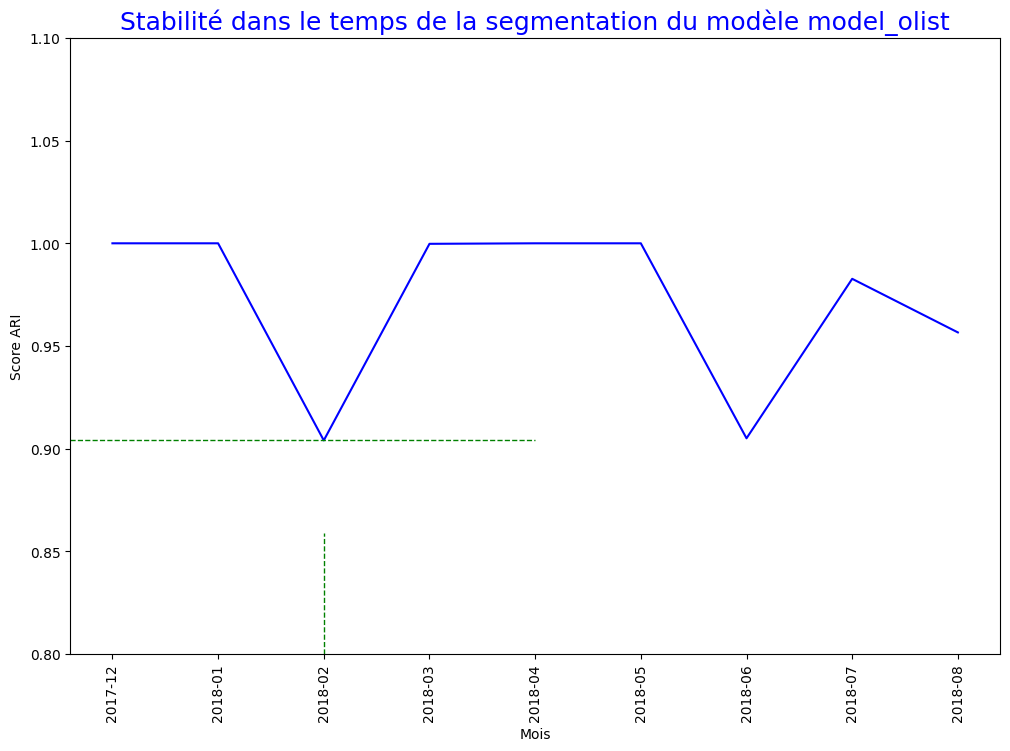

In [ ]:
# Création de la table ARI
ari_df = pd.DataFrame([[item[0], item[1]] for item in ari_list]
                      , columns=["mois", "ARI"])

# Visualisation de la stabilité du ARI au cours du temps avec le modèle
# sans la variable récence
fig = plt.figure(figsize=(12,8))
sns.lineplot(data=ari_df,
             color='blue',
             x="mois", 
             y="ARI")

plt.axhline(y=ari_df.iloc[2][1], linestyle="--", 
            color="green",
            xmax=0.5,
            linewidth=1)

plt.axvline(x=ari_df.iloc[2][0], linestyle="--", 
            color="green",
            ymax=1.1-(ari_df.iloc[2][1]),
            linewidth=1)

plt.title("Stabilité dans le temps de la segmentation du modèle model_olist",
          fontsize=18,
          color="b")
plt.xlabel("Mois")
plt.xticks(rotation=90)
plt.ylabel("Score ARI")
plt.ylim(0.8, 1.1)  # définition des limites de l'axe y

plt.show()

### __4.2 Sur la période de décembre 2017 et d'août 2018, avec la récence__

In [ ]:
month_list = create_month_list('2017-12', '2018-08')

In [ ]:
# Création des tables pour chaque mois AVEC la récence
table_list = []
for month in month_list:
    table = create_table_with_recency(month_year=month)
    table_list.append(table)

Memory usage reduced from 0.33 MB to 0.21 MB
The table for the 2017-12 period has being created in 2.50 seconds.
Memory usage reduced from 0.43 MB to 0.27 MB
The table for the 2018-01 period has being created in 2.55 seconds.
Memory usage reduced from 0.39 MB to 0.24 MB
The table for the 2018-02 period has being created in 2.38 seconds.
Memory usage reduced from 0.42 MB to 0.26 MB
The table for the 2018-03 period has being created in 2.82 seconds.
Memory usage reduced from 0.41 MB to 0.26 MB
The table for the 2018-04 period has being created in 2.87 seconds.
Memory usage reduced from 0.41 MB to 0.26 MB
The table for the 2018-05 period has being created in 2.30 seconds.
Memory usage reduced from 0.37 MB to 0.23 MB
The table for the 2018-06 period has being created in 2.60 seconds.
Memory usage reduced from 0.37 MB to 0.23 MB
The table for the 2018-07 period has being created in 2.41 seconds.
Memory usage reduced from 0.39 MB to 0.24 MB
The table for the 2018-08 period has being created 

In [ ]:
# Création de la liste ARI
ari_list = []
i = 0
for table in table_list:
  month = month_list[i]
  if table.equals(table_list[0]):
    ## Chargement du modèle K-Means SANS la récence depuis le fichier enregistré
    model_t0 = load("/content/drive/MyDrive/projet_5/data/recency_model.joblib")
    # Fit du modèle 0 sur T0
    model_t0.fit(table_list[0])
    # prediction du modèle 0 sur T0
    true_cluster = model_t0.predict(table)
    # Prédction sur le modèle actuel
    pred_cluster = model_t0.predict(table)
  else:
    # Prédiction sur le modèle T0 sur la table du mois en cours
    pred_cluster = model_t0.predict(table)

    # Prédiction du modèle en cours sur la table du mois en cours
    model = load("/content/drive/MyDrive/projet_5/data/recency_model.joblib")
    model.fit(table)
    true_cluster = model.predict(table)
  
  i += 1
  ari = adjusted_rand_score(true_cluster, pred_cluster)
  print(f"L'ARI pour le mois {month} est à {ari:.2f}")
  ari_list.append([month, ari])

L'ARI pour le mois 2017-12 est à 1.00
L'ARI pour le mois 2018-01 est à 1.00
L'ARI pour le mois 2018-02 est à 1.00
L'ARI pour le mois 2018-03 est à 1.00
L'ARI pour le mois 2018-04 est à 1.00
L'ARI pour le mois 2018-05 est à 1.00
L'ARI pour le mois 2018-06 est à 0.91
L'ARI pour le mois 2018-07 est à 0.91
L'ARI pour le mois 2018-08 est à 0.96


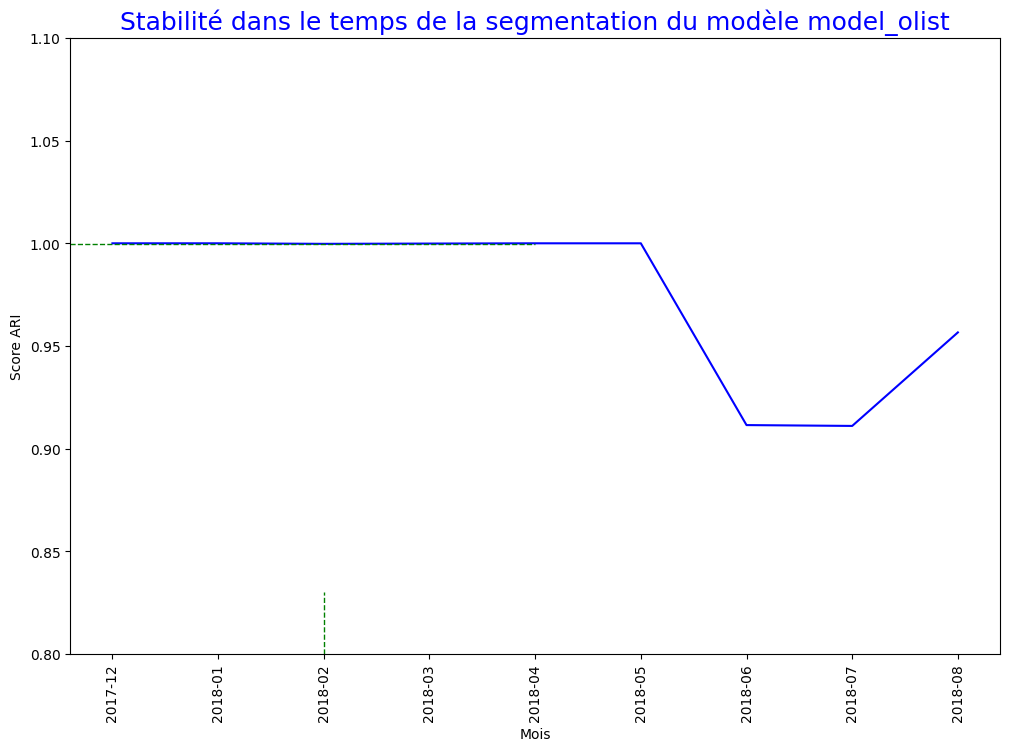

In [ ]:
# Création de la table ARI
ari_df = pd.DataFrame([[item[0], item[1]] for item in ari_list]
                      , columns=["mois", "ARI"])

# Visualisation de la stabilité du ARI au cours du temps avec le modèle
# sans la variable récence
fig = plt.figure(figsize=(12,8))
sns.lineplot(data=ari_df,
             color='blue',
             x="mois", 
             y="ARI")

plt.axhline(y=ari_df.iloc[2][1], linestyle="--", 
            color="green",
            xmax=0.5,
            linewidth=1)

plt.axvline(x=ari_df.iloc[2][0], linestyle="--", 
            color="green",
            ymax=1.1-(ari_df.iloc[2][1]),
            linewidth=1)

plt.title("Stabilité dans le temps de la segmentation du modèle model_olist",
          fontsize=18,
          color="b")
plt.xlabel("Mois")
plt.xticks(rotation=90)
plt.ylabel("Score ARI")
plt.ylim(0.8, 1.1)  # définition des limites de l'axe y

plt.show()

__Conclusion de ces deux sous-sections:__

Nous constatons de façon assez surprenante la resistance de notre modèle sur le temps. Peut-être que le cadre temporel est trop étroit et qu'il faut l'étendre pour mieux observer la dégradation du modèle au cours du temps. C'est pourquoi les deux sous-parties prochaines testent la qualité du modèle sur plus d'un an et demi de données. 


### __4.3 Sur un an et demi de données, sans la récence__

In [ ]:
# Création de la liste des mois pris en compte
month_list = create_month_list('2017-01', '2018-08')

In [ ]:
# Création des tables pour chaque mois SANS la récence
table_list = []
for month in month_list:
    table = create_table(month_year=month)
    table_list.append(table)

The table for the 2017-01 period has being created in 3.36 seconds.
The table for the 2017-02 period has being created in 2.98 seconds.
The table for the 2017-03 period has being created in 2.35 seconds.
The table for the 2017-04 period has being created in 2.36 seconds.
The table for the 2017-05 period has being created in 2.29 seconds.
The table for the 2017-06 period has being created in 2.94 seconds.
The table for the 2017-07 period has being created in 2.52 seconds.
The table for the 2017-08 period has being created in 2.32 seconds.
The table for the 2017-09 period has being created in 2.25 seconds.
The table for the 2017-10 period has being created in 2.29 seconds.
The table for the 2017-11 period has being created in 3.07 seconds.
The table for the 2017-12 period has being created in 2.56 seconds.
The table for the 2018-01 period has being created in 2.37 seconds.
The table for the 2018-02 period has being created in 2.44 seconds.
The table for the 2018-03 period has being creat

In [ ]:
# Création de la liste ARI
ari_list = []
i = 0
for table in table_list:
  month = month_list[i]
  if table.equals(table_list[0]):
    ## Chargement du modèle K-Means SANS la récence depuis le fichier enregistré
    model_t0 = load("/content/drive/MyDrive/projet_5/data/best_model.joblib")
    # Fit du modèle 0 sur T0
    model_t0.fit(table_list[0])
    # prediction du modèle 0 sur T0
    true_cluster = model_t0.predict(table)
    # Prédction sur le modèle actuel
    pred_cluster = model_t0.predict(table)
  else:
    # Prédiction sur le modèle T0 sur la table du mois en cours
    pred_cluster = model_t0.predict(table)

    # Prédiction du modèle en cours sur la table du mois en cours
    model = load("/content/drive/MyDrive/projet_5/data/best_model.joblib")
    model.fit(table)
    true_cluster = model.predict(table)
  
  i += 1
  ari = adjusted_rand_score(true_cluster, pred_cluster)
  print(f"L'ARI pour le mois {month} est à {ari:.2f}")
  ari_list.append([month, ari])

L'ARI pour le mois 2017-01 est à 1.00
L'ARI pour le mois 2017-02 est à 0.93
L'ARI pour le mois 2017-03 est à 0.98
L'ARI pour le mois 2017-04 est à 0.97
L'ARI pour le mois 2017-05 est à 0.92
L'ARI pour le mois 2017-06 est à 0.99
L'ARI pour le mois 2017-07 est à 0.99
L'ARI pour le mois 2017-08 est à 0.93
L'ARI pour le mois 2017-09 est à 1.00
L'ARI pour le mois 2017-10 est à 0.98
L'ARI pour le mois 2017-11 est à 0.96
L'ARI pour le mois 2017-12 est à 0.97
L'ARI pour le mois 2018-01 est à 0.97
L'ARI pour le mois 2018-02 est à 0.94
L'ARI pour le mois 2018-03 est à 0.94
L'ARI pour le mois 2018-04 est à 0.98
L'ARI pour le mois 2018-05 est à 0.98
L'ARI pour le mois 2018-06 est à 0.90
L'ARI pour le mois 2018-07 est à 0.91
L'ARI pour le mois 2018-08 est à 0.98


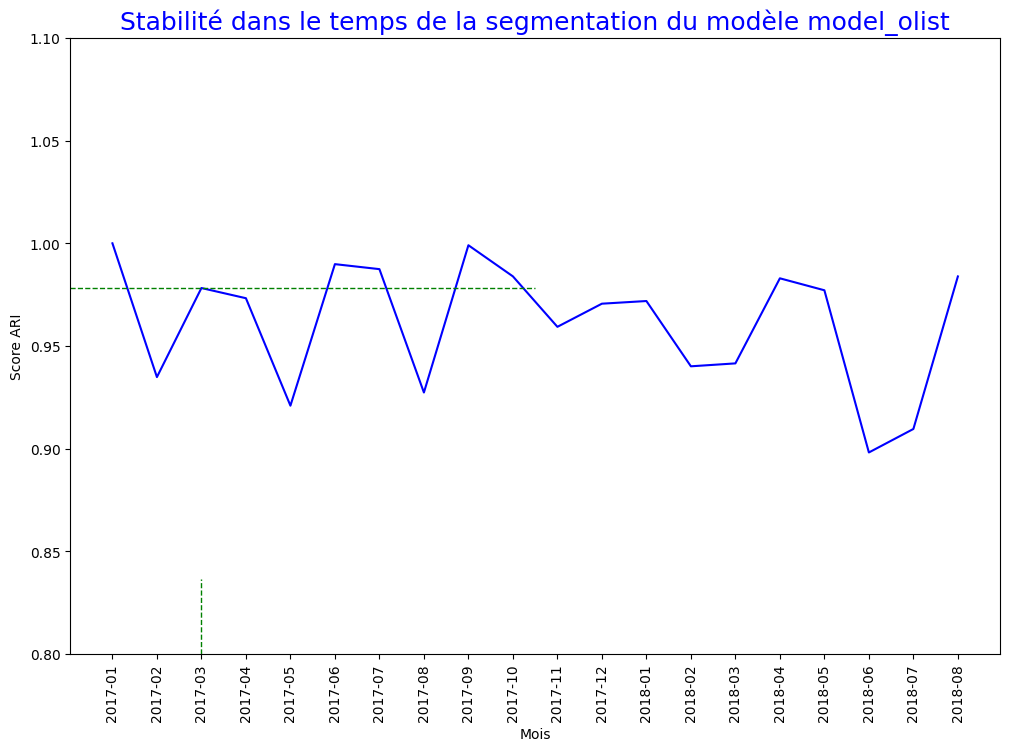

In [ ]:
# Création de la table ARI
ari_df = pd.DataFrame([[item[0], item[1]] for item in ari_list]
                      , columns=["mois", "ARI"])

# Visualisation de la stabilité du ARI au cours du temps avec le modèle
# sans la variable récence
fig = plt.figure(figsize=(12,8))
sns.lineplot(data=ari_df,
             color='blue',
             x="mois", 
             y="ARI")

plt.axhline(y=ari_df.iloc[2][1], linestyle="--", 
            color="green",
            xmax=0.5,
            linewidth=1)

plt.axvline(x=ari_df.iloc[2][0], linestyle="--", 
            color="green",
            ymax=1.1-(ari_df.iloc[2][1]),
            linewidth=1)

plt.title("Stabilité dans le temps de la segmentation du modèle model_olist",
          fontsize=18,
          color="b")
plt.xlabel("Mois")
plt.xticks(rotation=90)
plt.ylabel("Score ARI")
plt.ylim(0.8, 1.1)  # définition des limites de l'axe y

plt.show()

### __4.4 Sur un an et demi de données, avec la récence__

In [ ]:
month_list = create_month_list('2017-01', '2018-08')

In [ ]:
# Création des tables pour chaque mois AVEC la récence
table_list = []
for month in month_list:
    table = create_table_with_recency(month_year=month)
    table_list.append(table)

Memory usage reduced from 0.04 MB to 0.03 MB
The table for the 2017-01 period has being created in 2.53 seconds.
Memory usage reduced from 0.10 MB to 0.06 MB
The table for the 2017-02 period has being created in 2.43 seconds.
Memory usage reduced from 0.15 MB to 0.10 MB
The table for the 2017-03 period has being created in 2.88 seconds.
Memory usage reduced from 0.14 MB to 0.09 MB
The table for the 2017-04 period has being created in 2.70 seconds.
Memory usage reduced from 0.21 MB to 0.13 MB
The table for the 2017-05 period has being created in 2.41 seconds.
Memory usage reduced from 0.19 MB to 0.12 MB
The table for the 2017-06 period has being created in 2.29 seconds.
Memory usage reduced from 0.23 MB to 0.15 MB
The table for the 2017-07 period has being created in 2.53 seconds.
Memory usage reduced from 0.25 MB to 0.16 MB
The table for the 2017-08 period has being created in 3.95 seconds.
Memory usage reduced from 0.25 MB to 0.16 MB
The table for the 2017-09 period has being created 

In [ ]:
# Création de la liste ARI
ari_list = []
i = 0
for table in table_list:
  month = month_list[i]
  if table.equals(table_list[0]):
    ## Chargement du modèle K-Means SANS la récence depuis le fichier enregistré
    model_t0 = load("/content/drive/MyDrive/projet_5/data/recency_model.joblib")
    # Fit du modèle 0 sur T0
    model_t0.fit(table_list[0])
    # prediction du modèle 0 sur T0
    true_cluster = model_t0.predict(table)
    # Prédction sur le modèle actuel
    pred_cluster = model_t0.predict(table)
  else:
    # Prédiction sur le modèle T0 sur la table du mois en cours
    pred_cluster = model_t0.predict(table)

    # Prédiction du modèle en cours sur la table du mois en cours
    model = load("/content/drive/MyDrive/projet_5/data/recency_model.joblib")
    model.fit(table)
    true_cluster = model.predict(table)
  
  i += 1
  ari = adjusted_rand_score(true_cluster, pred_cluster)
  print(f"L'ARI pour le mois {month} est à {ari:.2f}")
  ari_list.append([month, ari])

L'ARI pour le mois 2017-01 est à 1.00
L'ARI pour le mois 2017-02 est à 0.89
L'ARI pour le mois 2017-03 est à 0.93
L'ARI pour le mois 2017-04 est à 0.91
L'ARI pour le mois 2017-05 est à 0.89
L'ARI pour le mois 2017-06 est à 0.87
L'ARI pour le mois 2017-07 est à 0.66
L'ARI pour le mois 2017-08 est à 0.84
L'ARI pour le mois 2017-09 est à 0.89
L'ARI pour le mois 2017-10 est à 0.87
L'ARI pour le mois 2017-11 est à 0.88
L'ARI pour le mois 2017-12 est à 0.94
L'ARI pour le mois 2018-01 est à 0.89
L'ARI pour le mois 2018-02 est à 0.86
L'ARI pour le mois 2018-03 est à 0.87
L'ARI pour le mois 2018-04 est à 0.93
L'ARI pour le mois 2018-05 est à 0.94
L'ARI pour le mois 2018-06 est à 0.88
L'ARI pour le mois 2018-07 est à 0.92
L'ARI pour le mois 2018-08 est à 0.93


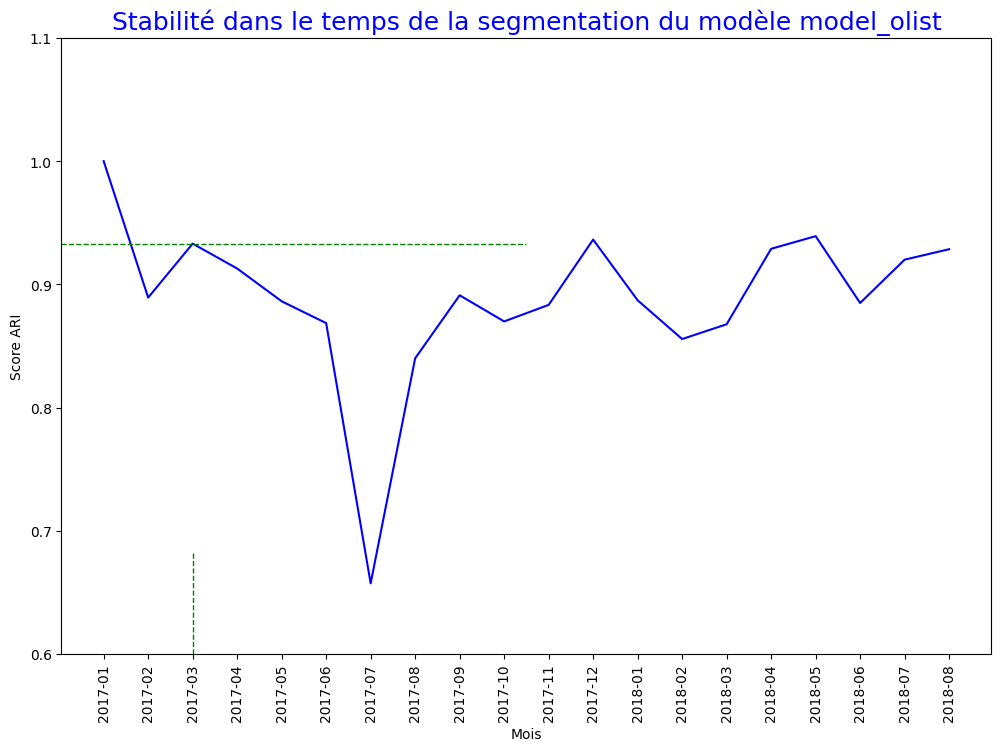

In [ ]:
# Création de la table ARI
ari_df = pd.DataFrame([[item[0], item[1]] for item in ari_list]
                      , columns=["mois", "ARI"])

# Visualisation de la stabilité du ARI au cours du temps avec le modèle
# sans la variable récence
fig = plt.figure(figsize=(12,8))
sns.lineplot(data=ari_df,
             color='blue',
             x="mois", 
             y="ARI")

plt.axhline(y=ari_df.iloc[2][1], linestyle="--", 
            color="green",
            xmax=0.5,
            linewidth=1)

plt.axvline(x=ari_df.iloc[2][0], linestyle="--", 
            color="green",
            ymax=1.1-(ari_df.iloc[2][1]),
            linewidth=1)

plt.title("Stabilité dans le temps de la segmentation du modèle model_olist",
          fontsize=18,
          color="b")
plt.xlabel("Mois")
plt.xticks(rotation=90)
plt.ylabel("Score ARI")
plt.ylim(0.6, 1.1)  # définition des limites de l'axe y

plt.show()

__Conclusion de ces deux dernières sous-sections:__

Encore une fois, le modèle reste étonnemment très robuste ! L'ARI ne descend pas plus bas que 0.66 (après 6 mois). Ainsi, nous pouvons proposer un contrat de maintenance tous les 6 mois si Olist une stabilité autour de 0.80 est suffisante. Par contre, si il veut une stabilité autour de 0.90, dès le 2e mois ou le 4e mois, il faudra penser à le faire maintenir. 

Cette stabilité pourrait en partie s'expliquer par le fait que seul 3% des clients reviennent sur le site pour commander au moins une nouvelle fois, ce qui pourrait ironiquement rendre notre modèle plus stable.

Dans tous les cas, nous allons garder le modèle avec la récence, non parce qu'il est forcément le plus performant mais parce qu'il contient la notion de récence et qu'il reste tout de même excellent. 

# __5. Conclusion__

Les scores ARI obtenus sont obtenus sur une période complète de 1 an et 8 mois et elles sont récupérées tous les mois.
Nous observons une stabilité du score ARI au cours du temps jusqu'au sixième mois. ensuite, il doit être refitter.  

Nous pouvons aussi proposer une nouvelle étude avec des données plus récente à Olist et où la récence est bien mieux représentée. Il y a de forte chance que si un certain nombre de clients ont commencé à se fidéliser, le preprocessing de la récence devienne caduque (il passe par un système de binarisation pour l'instant entre les clients ponctuels et les clients qui reviennent au moins une fois de plus commander sur le site). 

Il serait intéressant de revérifier la qualité du modèle après que le positionnement d'Olist sur le marché se soit stabilisé et que les cycles temporelles (fluctuations journalières, hedbodomaires et mensuelles typiques) soient bien identifiés. Nous verrons si nos personae restent stables ou si devrons les mettre à jour. 

